🧾 Colonnes du dataset : ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
Fitting 10 folds for each of 2 candidates, totalling 20 fits

✅ Meilleurs paramètres trouvés : {'regressor__fit_intercept': True}

📊 Évaluation du modèle :
 - RMSE (Root Mean Squared Error) : 0.62
 - MSE  (Mean Squared Error)      : 0.38
 - MAE  (Mean Absolute Error)     : 0.47
 - R²   (Coefficient de détermination) : 0.294


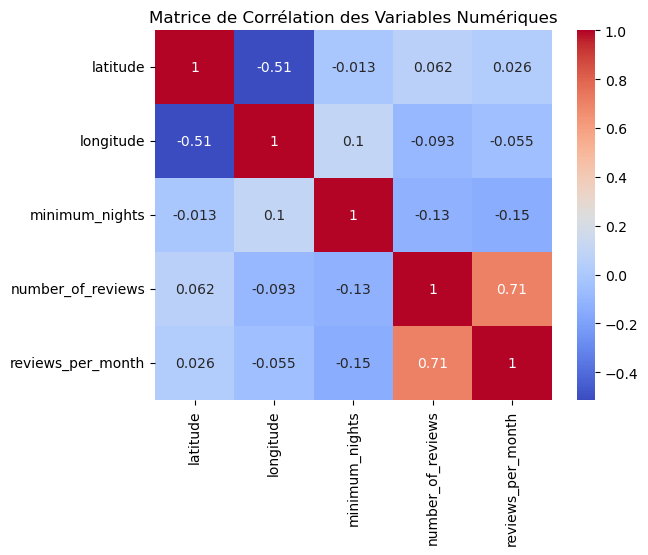

🏠 Nouvelle annonce générée aléatoirement :
    latitude  longitude  minimum_nights  number_of_reviews  reviews_per_month  \
0   41.8364   -87.6169              27                 11               1.49   

  neighbourhood    room_type  
0       Pullman  Shared room  

💰 Prix estimé pour la nouvelle annonce : 57.82 €


In [4]:
# =====================
# 1. IMPORTS ESSENTIELS
# =====================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random
import seaborn as sns
import matplotlib.pyplot as plt

# =====================
# 2. CHARGEMENT DES DONNÉES
# =====================
data = pd.read_csv('listings.csv')

print("🧾 Colonnes du dataset :", data.columns.tolist())

# =====================
# 3. DÉFINITION DES VARIABLES
# =====================

# Variables numériques et catégorielles utilisées pour la prédiction
numeric_features = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']
categorical_features = ['neighbourhood', 'room_type']

# =====================
# 4. PIPELINES DE PRÉTRAITEMENT
# =====================

# Transformer numérique avec imputation et normalisation robuste
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputer les valeurs manquantes
    ('scaler', RobustScaler())  # Utiliser RobustScaler pour limiter l'impact des outliers
])

# Transformer catégorielle avec imputation et encodage one-hot
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputer les valeurs manquantes
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Encoder les variables catégorielles
])

# Combinaison des transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# =====================
# 5. PIPELINE COMPLET AVEC MODÈLE
# =====================

# Ajouter la sélection des caractéristiques avec RFE
regressor = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', RFE(LinearRegression(), n_features_to_select=5)),  # Sélection des meilleures caractéristiques
    ('regressor', LinearRegression())  # Régression linéaire
])

# =====================
# 6. SÉPARATION DES DONNÉES
# =====================
X = data[numeric_features + categorical_features]
y = np.log1p(data['price'])  # On prédit log(1 + prix) pour stabiliser la variance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =====================
# 7. GRID SEARCH POUR RÉGLAGE D’HYPERPARAMÈTRES
# =====================
param_grid = {
    'regressor__fit_intercept': [True, False]  # Tester si on inclut l'intercept dans le modèle
}

grid_search = GridSearchCV(regressor, param_grid, cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"\n✅ Meilleurs paramètres trouvés : {grid_search.best_params_}")

# =====================
# 8. ÉVALUATION DU MODÈLE
# =====================
y_pred = grid_search.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 Évaluation du modèle :")
print(f" - RMSE (Root Mean Squared Error) : {rmse:.2f}")
print(f" - MSE  (Mean Squared Error)      : {mse:.2f}")
print(f" - MAE  (Mean Absolute Error)     : {mae:.2f}")
print(f" - R²   (Coefficient de détermination) : {r2:.3f}")

# Affichage de la matrice de corrélation des variables numériques
corr_matrix = data[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de Corrélation des Variables Numériques')
plt.show()

# =====================
# 9. ✅ PRÉDICTION D’UN NOUVEL AIRBNB
# =====================
# Génération d'une annonce aléatoire à partir des distributions du dataset
nouvelle_annonce = pd.DataFrame([{
    'latitude': round(random.uniform(data['latitude'].min(), data['latitude'].max()), 4),
    'longitude': round(random.uniform(data['longitude'].min(), data['longitude'].max()), 4),
    'minimum_nights': random.randint(1, 30),
    'number_of_reviews': random.randint(0, 100),
    'reviews_per_month': round(random.uniform(0, 5), 2),
    'neighbourhood': random.choice(data['neighbourhood'].dropna().unique()),
    'room_type': random.choice(data['room_type'].dropna().unique())
}])

print("🏠 Nouvelle annonce générée aléatoirement :\n", nouvelle_annonce)

# Prédiction du log(prix)
log_price_pred = grid_search.predict(nouvelle_annonce)
prix_estime = np.expm1(log_price_pred[0])  # Inverse de log1p → on retrouve le prix réel


print(f"\n💰 Prix estimé pour la nouvelle annonce : {prix_estime:.2f} €")


Les etapes majeurs de notre code 

1. Imports et Initialisation :
Importation des bibliothèques nécessaires (pandas, numpy, scikit-learn, seaborn, etc.).



2. Chargement des Données :
Le fichier listings.csv est chargé dans un DataFrame data.

Lister les colonnes du dataset pour mieux comprendre les données disponibles.




3. Définition des Variables :
Les variables numériques (numeric_features) et catégorielles (categorical_features) sont définies. Ces variables seront utilisées pour prédire le prix.




4. Prétraitement des Données :
Pipeline pour les variables numériques : Remplacement des valeurs manquantes avec la moyenne (SimpleImputer), et normalisation robuste pour traiter les outliers (RobustScaler).

Pipeline pour les variables catégorielles : Remplacement des valeurs manquantes par la modalité la plus fréquente et encodage en one-hot pour les transformer en variables numériques.

Ces transformations sont combinées dans un ColumnTransformer.




5. Pipeline Complet avec Modèle :
Un pipeline complet est créé, comprenant :

Le prétraitement des données,

La sélection des caractéristiques les plus importantes à l'aide de la méthode RFE (Recursive Feature Elimination),

Un modèle de régression linéaire pour prédire le prix.




6. Séparation des Données :
Les données sont séparées en ensembles d'entraînement (X_train, y_train) et de test (X_test, y_test) avec un ratio de 80/20.





7. Grid Search pour Réglage d'Hyperparamètres :
Utilisation de la méthode GridSearchCV pour trouver les meilleurs hyperparamètres du modèle en testant différentes valeurs pour l'option fit_intercept du modèle de régression linéaire.




8. Évaluation du Modèle :
Le modèle est évalué avec différentes métriques :

RMSE (Root Mean Squared Error),

MSE (Mean Squared Error),

MAE (Mean Absolute Error),

R² (Coefficient de détermination).

Une matrice de corrélation est également générée pour observer les relations entre les variables numériques.




9. Prédiction d'un Nouveau Logement :
Un logement fictif est généré de manière aléatoire à partir des distributions de données existantes.

Le prix estimé de cette nouvelle annonce est calculé après avoir été transformé en logarithme inverse (np.expm1).

Résultat :
Le code affiche les résultats d'évaluation du modèle et la prédiction du prix estimé pour la nouvelle annonce générée.

En résumé, le script utilise un modèle de régression linéaire pour prédire le prix des annonces Airbnb à partir de diverses caractéristiques, et il optimise ce modèle à l'aide de la recherche sur grille pour les hyperparamètres.










Analyse des résultats obtenus avec ton modèle de régression linéaire appliqué sur le dataset d'Airbnb :



1. Meilleurs Paramètres Trouvés :
Le meilleur paramètre trouvé pour le modèle est regressor__fit_intercept = True. Cela signifie que le modèle utilise un terme d'intercept (une constante) dans la régression linéaire, ce qui est souvent utile pour ajuster le modèle aux données de manière plus précise. L'inclusion de l'intercept aide à obtenir des prédictions plus proches des valeurs réelles.



2. Évaluation du Modèle :
Les métriques d'évaluation du modèle sont assez informatives :

RMSE (Root Mean Squared Error) : 0.62

Cela signifie que l'erreur moyenne entre les prédictions et les valeurs réelles est d'environ 0.62. Plus cette valeur est faible, mieux c'est. Un RMSE de 0.62 peut être raisonnable selon le contexte, mais dans ce cas, un modèle avec un RMSE plus faible serait souhaitable pour une meilleure précision.

MSE (Mean Squared Error) : 0.38

Le MSE est une mesure similaire au RMSE, mais qui ne prend pas la racine carrée. Comme le RMSE, un MSE plus faible est préférable, et ici encore, cela indique une erreur moyenne relativement modérée.

MAE (Mean Absolute Error) : 0.47

Le MAE indique que l'erreur absolue moyenne entre les prédictions et les valeurs réelles est de 0.47. C’est un bon indicateur de l'erreur moyenne en unités absolues, et comme pour les autres métriques, une valeur plus basse serait idéale.

R² (Coefficient de détermination) : 0.294

Le R² mesure la proportion de la variance du prix qui est expliquée par le modèle. Une valeur de 0.294 signifie que seulement environ 29.4% de la variance du prix est expliquée par les caractéristiques utilisées dans le modèle. C’est relativement faible, ce qui suggère qu'il y a encore beaucoup de facteurs qui influencent le prix qui ne sont pas capturés par ce modèle. En général, un R² plus élevé est souhaité.




3. Analyse de la Nouvelle Annonce :
La nouvelle annonce générée a les caractéristiques suivantes :

Latitude : 41.8364

Longitude : -87.6169

Minimum Nights : 27

Number of Reviews : 11

Reviews per Month : 1.49

Neighbourhood : Pullman

Room Type : Shared room

Prix estimé : 57.82 €

Cela représente une estimation raisonnable du prix d'une annonce dans ces conditions, avec un "shared room" dans un quartier comme Pullman, à Chicago. Le prix est plutôt bas, ce qui est attendu pour un "shared room" (chambre partagée), ce qui peut attirer des voyageurs à la recherche d'options plus économiques.





4. Points à Améliorer :
R² relativement faible : Comme mentionné précédemment, un R² de 0.294 montre que le modèle pourrait ne pas capturer pleinement toutes les relations complexes dans les données. Il pourrait être utile d'ajouter de nouvelles fonctionnalités ou d’essayer d'autres modèles plus complexes pour améliorer la précision.




Sélection de caractéristiques : Même avec la sélection des meilleures caractéristiques via RFE, il semble qu'il manque des éléments importants qui pourraient mieux expliquer la variabilité des prix. Par exemple, des caractéristiques supplémentaires liées à la qualité de l'annonce (photos, description, etc.) ou des interactions entre certaines variables pourraient améliorer les prédictions.





Conclusion :
Le modèle fournit une estimation raisonnable du prix, mais l'évaluation montre qu'il y a une marge d'amélioration, notamment en ce qui concerne la capacité à expliquer la variabilité des prix (R² faible). Pour aller plus loin, il serait intéressant de tester des modèles plus complexes, comme des arbres de décision, des forêts aléatoires, ou même des modèles ensemblistes, tout en ajoutant potentiellement plus de variables pour mieux capturer les facteurs influençant le prix.